In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from mplsoccer.pitch import Pitch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import math
import os
import joblib
import pickle
from sklearn.preprocessing import RobustScaler
from ipynb.fs.defs.PassesData import get_df_passes
from ipynb.fs.defs.ExpectedGoalsData import get_df_shots
import PassingEvaluation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
plt.style.use('fivethirtyeight')
params = {'axes.titlesize': 'x-large',
          'axes.labelsize': 'large', 
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [3]:
matches = pd.read_excel('extracted_data/matches.xlsx')
players = pd.read_excel('extracted_data/players.xlsx')

In [4]:
matches = matches[(matches['competition_id'] == 2) | ((matches['competition_id'] == 11) & (matches['season'].isin(['2014/2015', '2006/2007'])))]

In [5]:
def get_player_name(player_id):
    if pd.notna(players.loc[players['player_id'] == player_id, 'player_nickname'].iloc[0]):
        return players.loc[players['player_id'] == player_id, 'player_nickname'].iloc[0]
    else:
        return players.loc[players['player_id'] == player_id, 'player_name'].iloc[0]

In [6]:
# get events
events_folder = 'data/events'
events = pd.concat([pd.DataFrame(json.load(open(os.path.join(events_folder, str(match_id) + '.json'), encoding='utf8'))).assign(match_id=match_id) for match_id in matches['match_id'].unique()])
events.reset_index(inplace=True)

In [7]:
xg_chain_events, passes, shots = PassingEvaluation.get_competition_data(matches)

In [8]:
players_playtime = PassingEvaluation.calculate_players_playtime(matches)

In [9]:
passes = PassingEvaluation.calculate_pass_effectivenesses(passes, xg_chain_events)

In [10]:
passes = PassingEvaluation.calculate_pass_scores(passes)

In [11]:
def scale_values(values, start=1, end=10):
    width = (end-1) - (start+1)
    max_value = np.percentile(values, 95)
    min_value = np.percentile(values, 5)
    results = [end if value > max_value else start if value < min_value else (value - min_value)/(max_value - min_value) * width + start + 1 for value in values]
    return results

In [12]:
def create_player_profiles(events, passes, shots, players_playtime, min_playtime=1000):
    player_profiles = pd.DataFrame(columns=['player_id', 'Spieler', 'Position', 'Spiele', 'Spielminuten', 
                                            'Passeffektivität', 'Kreativität', 'Torgefährlichkeit', 'Chancenverwertung',
                                            'Dribbling', 'Zweikämpfe', 'Verteidigung', 'Kopfbälle', 'Gesamtwert'])
    events.loc[:, 'player_id'] = [events['player'].iloc[i]['id'] if not pd.isna(events['player'].iloc[i]) else -1 for i in range(len(events))]
    events.loc[:, 'position_id'] = [events['position'].iloc[i]['id'] if not pd.isna(events['position'].iloc[i]) else -1 for i in range(len(events))]
    player_ids = events['player_id'].unique()
    player_ids = player_ids[player_ids != -1]
    player_ids = [player_id for player_id in player_ids if players_playtime[player_id] >= min_playtime]
    player_ids = [player_id for player_id in player_ids if events.loc[events['player_id'] == player_id, 'position_id'].iloc[0] != 1]
    for player_id in player_ids:
        pos = events.loc[events['player_id'] == player_id, 'position_id'].iloc[0]
        position = 'Torwart' if pos == 1 else 'Verteidiger' if pos <= 8 else 'Mittelfeldspieler' if pos <= 21 else 'Stürmer'
        player_profiles = player_profiles.append(pd.Series({'player_id': player_id, 'Spieler': get_player_name(player_id),
                                                            'Position': position,
                                                            'Spiele': len(events.loc[events['player_id'] == player_id, 'match_id'].unique()),
                                                            'Spielminuten': players_playtime[player_id]}), ignore_index=True)
        
    # calculate a score between 1 and 10 for the passeffectiveness for every player
    for player_id in player_ids:
        pass_effect_sum = passes.loc[passes['player_id'] == player_id, 'pass_effectiveness'].sum()
        num_minutes = players_playtime[player_id]
        pass_effect = np.round(90 * pass_effect_sum / num_minutes, 2)
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Passeffektivität'] = pass_effect
    player_profiles['Passeffektivität'] = player_profiles['Passeffektivität'].astype(float)
    player_profiles['Passeffektivität'] = scale_values(player_profiles['Passeffektivität'])
    
    # calculate a score between 1 and 10 for the creativity for every player
    for player_id in player_ids:
        expected_accuracy = passes.loc[passes['player_id'] == player_id, 'pred_accuracy'].mean()
        actual_accuracy = passes.loc[passes['player_id'] == player_id, 'complete'].mean()
        creativity = (1 - expected_accuracy) * (1 + actual_accuracy - expected_accuracy)
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Kreativität'] = creativity
    player_profiles['Kreativität'] = player_profiles['Kreativität'].astype(float)
    player_profiles['Kreativität'] = scale_values(player_profiles['Kreativität'])
    
    # calculate a score between 1 and 10 for the goal-thread for every player
    for player_id in player_ids:
        shots_xg_sum = shots.loc[shots['player_id'] == player_id, 'pred_xg'].sum()
        assists_xg_sum = shots.loc[shots['assistant_id'] == player_id, 'pred_xg'].sum()
        goal_thread = 1.1 * shots_xg_sum + 0.9 * assists_xg_sum
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Torgefährlichkeit'] = goal_thread
    player_profiles['Torgefährlichkeit'] = player_profiles['Torgefährlichkeit'].astype(float)
    player_profiles['Torgefährlichkeit'] = scale_values(player_profiles['Torgefährlichkeit'])
    
    # calculate a score between 1 and 10 for the finishing for every player
    for player_id in player_ids:
        expected_goals = shots.loc[shots['player_id'] == player_id, 'pred_xg'].sum()
        actual_goals = shots.loc[shots['player_id'] == player_id, 'goal'].sum()
        finishing = actual_goals - expected_goals
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Chancenverwertung'] = finishing
    player_profiles['Chancenverwertung'] = player_profiles['Chancenverwertung'].astype(float)
    player_profiles['Chancenverwertung'] = scale_values(player_profiles['Chancenverwertung'])
    
    # calculate a score between 1 and 10 for dribbling for every player
    for player_id in player_ids:
        dribbles = events.loc[(events['player_id'] == player_id) & (~events['dribble'].isna())]
        dribbles.loc[:, 'won'] = [1 if dribbles['dribble'].iloc[i]['outcome']['id'] == 8 else 0 for i in range(len(dribbles))]
        #pct_dribbles = dribbles['won'].mean()
        #dribbling = (90 * (len(dribbles) / 3) / players_playtime[player_id]) * pct_dribbles
        dribbling = 90 * dribbles['won'].sum() / players_playtime[player_id]
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Dribbling'] = dribbling
    player_profiles['Dribbling'] = player_profiles['Dribbling'].astype(float)
    player_profiles['Dribbling'] = scale_values(player_profiles['Dribbling'])
    
    # calculate a score between 1 and 10 for the duels for every player
    for player_id in player_ids:
        duels = events.loc[(events['player_id'] == player_id) & (~events['duel'].isna())]
        duels.loc[:, 'tackle'] = [0 if ('type' in duels['duel'].iloc[i].keys()) & (duels['duel'].iloc[i]['type']['id'] == 10) else 1 for i in range(len(duels))]
        duels = duels[duels['tackle'] == 1]
        duels.loc[:, 'won'] = [1 if duels['duel'].iloc[i]['outcome']['id'] in [4,15,16,17] else 0 for i in range(len(duels))]
        #pct_duels = duels['won'].mean()
        #duel_strenght = (90 * (len(duels) / 5) / players_playtime[player_id]) * pct_duels
        duel_strenght = 90 * duels['won'].sum() / players_playtime[player_id]
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Zweikämpfe'] = duel_strenght
    player_profiles['Zweikämpfe'] = player_profiles['Zweikämpfe'].astype(float)
    player_profiles['Zweikämpfe'] = scale_values(player_profiles['Zweikämpfe'])
    
    # calculate a score between 1 and 10 for the defense for every player
    for player_id in player_ids:
        interceptions = events.loc[(events['player_id'] == player_id) & (~events['interception'].isna())]
        interceptions.loc[:, 'won'] = [1 if interceptions['interception'].iloc[i]['outcome']['id'] in [4,15,16,17] else 0 for i in range(len(interceptions))]
        num_intercepts = interceptions['won'].sum()
        num_clearances = len(events.loc[(events['player_id'] == player_id) & (~events['clearance'].isna())])
        num_blocks = len(events.loc[(events['player_id'] == player_id) & (~events['block'].isna())])
        defense = 90 * (num_intercepts + num_clearances + num_blocks) / players_playtime[player_id]
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Verteidigung'] = defense
    player_profiles['Verteidigung'] = player_profiles['Verteidigung'].astype(float)
    player_profiles['Verteidigung'] = scale_values(player_profiles['Verteidigung'])
    
    # calculate a score between 1 and 10 for headers for every player
    for player_id in player_ids:
        clearances = events.loc[(events['player_id'] == player_id) & (~events['clearance'].isna())]
        clearances.loc[:, 'aerial_won'] = [1 if 'aerial_won' in clearances['clearance'].iloc[i].keys() else 0 for i in range(len(clearances))]
        num_clearances = clearances['aerial_won'].sum()
        player_passes = events.loc[(events['player_id'] == player_id) & (~events['pass'].isna())]
        player_passes.loc[:, 'header'] = [1 if ('body_part' in player_passes['pass'].iloc[i].keys()) and (player_passes['pass'].iloc[i]['body_part']['id'] == 37) else 0 for i in range(len(player_passes))]
        player_passes.loc[:, 'complete'] = [1 if 'outcome' not in player_passes['pass'].iloc[i].keys() else 0 for i in range(len(player_passes))]
        num_passes = len(player_passes[(player_passes['header'] == 1) & (player_passes['complete'] == 1)])
        player_shots = events.loc[(events['player_id'] == player_id) & (~events['shot'].isna())]
        player_shots.loc[:, 'header'] = [1 if player_shots['shot'].iloc[i]['body_part']['id'] == 37 else 0 for i in range(len(player_shots))]
        player_shots.loc[:, 'goal'] = [1 if player_shots['shot'].iloc[i]['outcome']['id'] == 97 else 0 for i in range(len(player_shots))]
        num_shots = len(player_shots[(player_shots['header'] == 1) & (player_shots['goal'] == 0)])
        num_goals = len(player_shots[(player_shots['header'] == 1) & (player_shots['goal'] == 1)])
        headers = 90 * (num_clearances + num_passes + 2*num_shots + 4*num_goals) / players_playtime[player_id]
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Kopfbälle'] = headers
    player_profiles['Kopfbälle'] = player_profiles['Kopfbälle'].astype(float)
    player_profiles['Kopfbälle'] = scale_values(player_profiles['Kopfbälle'])
    
    # calculate a score between 1 and 10 for the overall score for every player
    for player_id in player_ids:
        player_profile = player_profiles[player_profiles['player_id'] == player_id].iloc[0]
        overall_score = player_profile[['Passeffektivität', 'Kreativität', 'Torgefährlichkeit', 'Chancenverwertung',
                                        'Dribbling', 'Zweikämpfe', 'Verteidigung', 'Kopfbälle']].mean()
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Gesamtwert'] = overall_score
    player_profiles['Gesamtwert'] = player_profiles['Gesamtwert'].astype(float)
    
    # characterize players based on their attributes
    attribute_to_describtion = {'Passeffektivität': 'Spielmacher', 'Kreativität': 'Genie', 
                                'Torgefährlichkeit': 'Chancenkreierer', 'Chancenverwertung': 'Torjäger', 
                                'Dribbling': 'Künstler', 'Zweikämpfe': 'Kämpfer', 
                                'Verteidigung': 'Defensivspezialist', 'Kopfbälle': 'Kopfballungeheuer'}
    for player_id in player_ids:
        player_profile = player_profiles[player_profiles['player_id'] == player_id].iloc[0]
        best_attribute = pd.to_numeric(player_profile[['Passeffektivität', 'Kreativität', 'Chancenverwertung', 
                                       'Torgefährlichkeit', 'Dribbling', 'Zweikämpfe', 'Verteidigung', 'Kopfbälle']]).idxmax()
        describtion = attribute_to_describtion[best_attribute]
        player_profiles.loc[player_profiles['player_id'] == player_id, 'Charakterisierung'] = describtion
    
    return player_profiles

In [13]:
player_profiles = create_player_profiles(events, passes, shots, players_playtime)

In [14]:
player_profiles

,player_id,Spieler,Position,Spiele,Spielminuten,Passeffektivität,Kreativität,Torgefährlichkeit,Chancenverwertung,Dribbling,Zweikämpfe,Verteidigung,Kopfbälle,Gesamtwert,Charakterisierung
0,4320,Neymar,Mittelfeldspieler,33,2631,2.923824,6.803256,8.694933,7.926082,10.000000,5.401698,2.313065,4.160165,6.027878,Künstler
1,5503,Lionel Messi,Stürmer,64,5514,4.819201,7.082863,10.000000,10.000000,10.000000,2.631204,1.000000,3.395259,6.116066,Torjäger
2,5203,Sergio Busquets,Mittelfeldspieler,33,2554,8.777273,2.026527,2.314416,4.802966,3.035869,8.946508,4.495396,5.387707,4.973333,Kämpfer
3,22102,Adriano,Verteidiger,18,1154,5.082524,4.087752,2.236815,3.685301,3.613143,7.967012,3.967631,3.883748,4.315491,Kämpfer
4,5506,Javier Mascherano,Verteidiger,28,2319,10.000000,2.777669,1.000000,4.203097,2.188417,8.575335,5.186157,3.937416,4.733511,Spielmacher
5,10609,Jérémy Mathieu,Verteidiger,28,2169,6.635031,3.242377,2.113444,5.389819,2.454541,4.165186,6.062897,6.218580,4.535235,Spielmacher
6,4324,Dani Alves,Verteidiger,32,2782,6.133072,6.442215,3.566892,3.095951,4.571657,10.000000,3.988671,3.686236,5.185587,Kämpfer
7,5470,Ivan Rakitić,Mittelfeldspieler,32,2089,6.763950,4.771123,3.375638,6.986462,3.036299,3.612639,3.417413,4.522028,4.560694,Torjäger
8,20131,Xavi,Mittelfeldspieler,54,3893,10.000000,3.342903,5.063033,3.022983,4.109337,4.755609,3.119952,2.467431,4.485156,Spielmacher
9,7068,Marc Bartra,Verteidiger,14,1064,6.785893,2.167053,2.150654,4.170309,2.239229,5.834537,8.784945,10.000000,5.266578,Kopfballungeheuer


In [15]:
def visualize_player_profiles(player_ids):
    plt.figure(figsize=(15,15))
    circles = []
    for i in range(11,0,-1):
        col = 'white'
        if i % 2 == 0:
            col = 'lightgray'
        circles.append(plt.Circle((6,6), i/2, color=col, fill=True))
    ax = plt.gca()
    ax.set_xlim((0, 12))
    ax.set_ylim((0, 12))
    for circle in circles:
        ax.add_patch(circle)
    plt.plot([6,6], [0.5,11.5], color='black')
    plt.plot([0.5,11.5], [6,6], color='black')
    plt.plot([2.1,9.9], [2.1,9.9], color='black')
    plt.plot([2.1,9.9], [9.9,2.1], color='black')
    plt.text(6, 11.7, 'Passeffektivität', ha='center', fontsize=22)
    plt.text(10.1, 10.1, 'Kreativität', rotation=-45, ha='center', va='center', fontsize=22)
    plt.text(11.7, 6, 'Torgefährlichkeit', rotation=-90, va='center', fontsize=22)
    plt.text(10.1, 1.9, 'Chancenverwertung', rotation=45, ha='center', va='center', fontsize=22)
    plt.text(6, 0.1, 'Dribbling', ha='center', fontsize=22)
    plt.text(1.9, 1.9, 'Zweikämpfe', rotation=-45, ha='center', va='center', fontsize=22)
    plt.text(0.1, 6, 'Verteidigung', rotation=90, va='center', fontsize=22)
    plt.text(1.9, 10.1, 'Kopfbälle', rotation=45, ha='center', va='center', fontsize=22)
    for i in range(1,11):
        plt.text(5.9, 6.5+(i/2), str(i), ha='right', va='center', fontsize=12)
        plt.text(5.9, 5.5-(i/2), str(i), ha='right', va='center', fontsize=12)
        plt.text(6.5+(i/2), 6.1, str(i), ha='center', fontsize=12)
        plt.text(5.5-(i/2), 6.1, str(i), ha='center', fontsize=12)
        plt.text(6.25+np.sqrt(i**2/2)/2, 6.45+np.sqrt(i**2/2)/2, str(i), ha='center', va='center', fontsize=12)
        plt.text(5.75-np.sqrt(i**2/2)/2, 6.45+np.sqrt(i**2/2)/2, str(i), ha='center', va='center', fontsize=12)
        plt.text(6.45+np.sqrt(i**2/2)/2, 5.75-np.sqrt(i**2/2)/2, str(i), ha='center', va='center', fontsize=12)
        plt.text(5.55-np.sqrt(i**2/2)/2, 5.75-np.sqrt(i**2/2)/2, str(i), ha='center', va='center', fontsize=12)
    player_names = []
    describtion_names = []
    colors = ['green', 'red', 'blue']
    color_idx = 0
    for player_id in player_ids:
        player_profile = player_profiles[player_profiles['player_id'] == player_id].iloc[0]
        loc_scores = []
        loc_scores.append([6, 6.5+player_profile['Passeffektivität']/2])
        loc_scores.append([6.35+np.sqrt(player_profile['Kreativität']**2/2)/2, 6.35+np.sqrt(player_profile['Kreativität']**2/2)/2])
        loc_scores.append([6.5+player_profile['Torgefährlichkeit']/2, 6])
        loc_scores.append([6.35+np.sqrt(player_profile['Chancenverwertung']**2/2)/2, 5.65-np.sqrt(player_profile['Chancenverwertung']**2/2)/2])
        loc_scores.append([6, 5.5-player_profile['Dribbling']/2])
        loc_scores.append([5.65-np.sqrt(player_profile['Zweikämpfe']**2/2)/2, 5.65-np.sqrt(player_profile['Zweikämpfe']**2/2)/2])
        loc_scores.append([5.5-player_profile['Verteidigung']/2, 6])
        loc_scores.append([5.65-np.sqrt(player_profile['Kopfbälle']**2/2)/2, 6.35+np.sqrt(player_profile['Kopfbälle']**2/2)/2])
        cent=(sum([loc[0] for loc in loc_scores])/len(loc_scores),sum([loc[1] for loc in loc_scores])/len(loc_scores))
        loc_scores.sort(key=lambda loc: math.atan2(loc[1]-cent[1],loc[0]-cent[0]))
        polygon = Polygon(loc_scores, closed=True, alpha=0.8, color=colors[color_idx % len(colors)], label=get_player_name(player_id))
        ax.add_patch(polygon)
        color_idx += 1
        player_names.append(get_player_name(player_id))
        describtion_names.append(str(player_profile['Charakterisierung']))
    plt.xticks([])
    plt.yticks([])
    players = ', '.join(player_names[:-1])
    describtions = ', '.join(describtion_names[:-1])
    if len(player_names) > 1:
        players += ' und ' + player_names[len(player_names)-1]
        describtions += ' und ' + describtion_names[len(describtion_names)-1]
        plt.title('Spielerprofil von ' + players + '\nCharakterisierungen: ' + describtions, fontsize=24, pad=30)
        plt.legend()
    else:
        plt.title('Spielerprofil von ' + player_names[0] + '\nGesamtwert: ' + 
                  str(np.round(player_profile['Gesamtwert'], 2)) + ' | Charakterisierung: ' + 
                  str(player_profile['Charakterisierung']), fontsize=24, pad=30)
    plt.show()

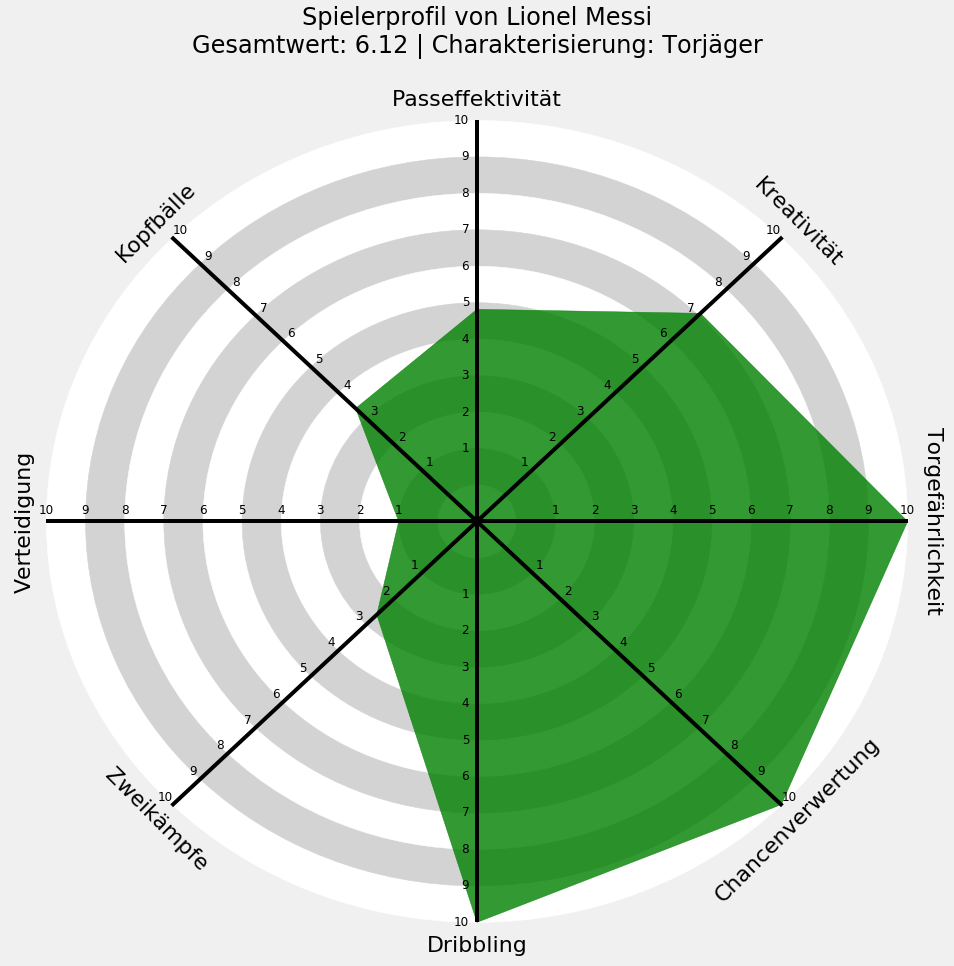

In [16]:
visualize_player_profiles([5503])

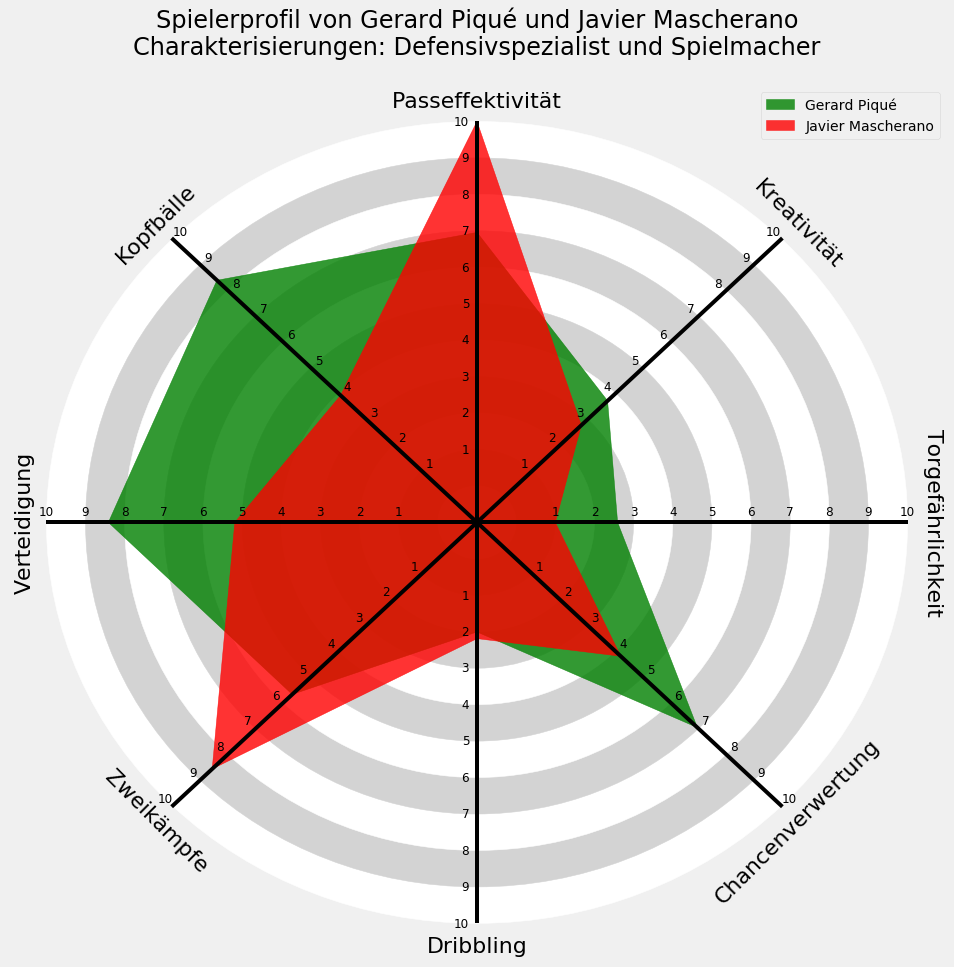

In [17]:
visualize_player_profiles([5213, 5506])